# Dog Breeds

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pip install opencv-python pandas-summary isoweek torchtext graphviz sklearn_pandas
# conda install bcolz tqdm

# conda install pytorch torchvision cuda80 -c soumith
# 

# sudo apt install graphviz

In [3]:
from fastai.fastai.imports import *
from fastai.fastai.torch_imports import *
from fastai.fastai.transforms import *
from fastai.fastai.conv_learner import *
from fastai.fastai.model import *
from fastai.fastai.dataset import *
from fastai.fastai.sgdr import *
from fastai.fastai.plots import *

In [4]:
torch.cuda.set_device(0)

In [5]:
PATH = './dataset/dog-breeds/'
sz=224
arch=resnext101_64
bs=58

In [6]:
# validation indeices
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [7]:
len(val_idxs)

2044

## Initial exploration

In [8]:
!ls {PATH}

labels.csv  sample_submission.csv.zip  test  tmp  train


In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs,
                                    suffix='.jpg',
                                    tfms=tfms, 
                                    bs=bs)

In [13]:
fn = PATH + data.trn_ds.fnames[0]
fn

'./dataset/dog-breeds/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

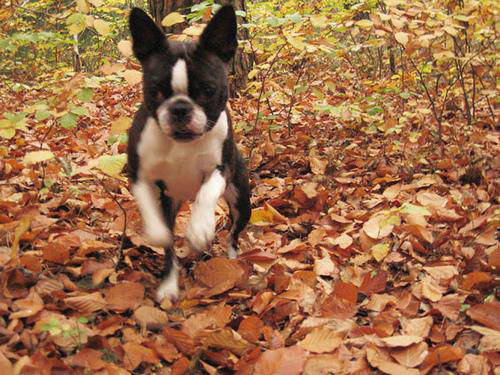

In [14]:
img = PIL.Image.open(fn)
img

In [15]:
img.size

(500, 375)

In [16]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [17]:
row_sz, col_sz = list(zip(*size_d.values()))

In [18]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [19]:
row_sz[:5]

array([500, 500, 400, 500, 231])

In [20]:
col_sz[:5]

array([375, 375, 344, 470, 227])

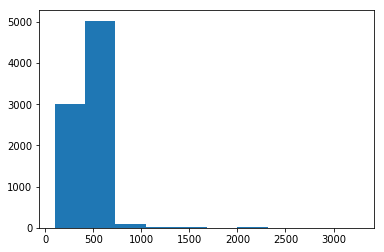

In [21]:
plt.hist(row_sz)
plt.show()

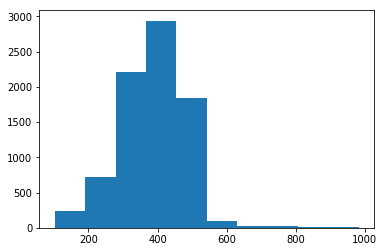

In [22]:
plt.hist(col_sz[col_sz<1000])
plt.show()

In [23]:
len(data.trn_ds)
#len(data.test_ds)

8178

In [24]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial model

In [25]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                        'train', 
                                        f'{PATH}labels.csv', 
                                        test_name='test', 
                                        num_workers=1,
                                        val_idxs=val_idxs,
                                        suffix='.jpg',
                                        tfms=tfms,
                                        bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

### Precompute

In [26]:
data = get_data(sz, bs)

A Jupyter Widget

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
learn.fit(1e-2, 5)

A Jupyter Widget

[ 0.       0.87293  0.37194  0.92146]                        
[ 1.       0.42581  0.29463  0.92433]                         
[ 2.       0.31043  0.25752  0.92666]                         
[ 3.       0.21138  0.2403   0.93199]                         
[ 4.       0.19179  0.23269  0.93056]                         



### Augment

In [27]:
from sklearn import metrics

In [28]:
data = get_data(sz, bs)

A Jupyter Widget

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [46]:
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       1.07909  0.42218  0.91379]                        
[ 1.       0.52303  0.30139  0.92433]                        



In [30]:
learn.precompute=False

In [48]:
learn.fit(1e-2, 5, cycle_len=1)

A Jupyter Widget

[ 0.       0.42154  0.26602  0.92481]                        
[ 1.       0.418    0.25215  0.92912]                        
[ 2.       0.38878  0.24833  0.93008]                        
[ 3.       0.34178  0.23896  0.93199]                        
[ 4.       0.33669  0.23143  0.93199]                        



In [49]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

### Increase size

In [31]:
learn.set_data(get_data(299, bs))

A Jupyter Widget

In [32]:
learn.freeze()

In [52]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.32904  0.2255   0.93008]                        
[ 1.       0.31705  0.21841  0.93576]                        
[ 2.       0.2987   0.21449  0.93336]                        



In [53]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.25687  0.21193  0.93384]                        
[ 1.       0.27696  0.20859  0.93671]                        
[ 2.       0.23866  0.20834  0.93767]                        
[ 3.       0.25106  0.20752  0.9324 ]                        
[ 4.       0.2312   0.20831  0.93576]                        
[ 5.       0.20352  0.20209  0.93671]                        
[ 6.       0.19862  0.20425  0.93623]                        



In [54]:
learn.save('299_pre')

In [35]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

(0.93835616438356162, 0.20075584548261735)

In [54]:
learn.save('299_pre')

In [55]:
print(learn.data.path)

./dataset/dog-breeds/tmp/340


In [33]:
learn.load('299_pre')

In [ ]:
learn.fit(1e-2, 1, cycle_len=2)

In [ ]:
learn.save('299_pre')

In [36]:
test_log_preds, test_y = learn.TTA(is_test=True)

In [37]:
type(test_log_preds)

numpy.ndarray

In [38]:
test_log_preds.shape

(10357, 120)

In [40]:
y.shape

(2044,)

In [59]:
np.save("test_log_preds", test_log_preds)

In [42]:
probs = np.exp(test_log_preds)

In [60]:
np.save("probs", probs)

In [61]:
np.argmax(probs[4])

35

In [35]:
probs = np.load("probs.npy")

In [36]:
type(learn.data.test_dl)

fastai.fastai.dataset.ModelDataLoader

In [37]:
submission_df = pd.read_csv("./dataset/dog-breeds/sample_submission.csv.zip")

In [38]:
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [39]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 121 entries, id to yorkshire_terrier
dtypes: float64(120), object(1)
memory usage: 9.6+ MB


In [40]:
probs_df = pd.DataFrame(probs, columns=data.classes)

In [41]:
probs_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,6.370176e-06,1.959119e-06,1.576018e-06,1.971664e-06,1.761157e-06,6.594638e-08,1.530113e-06,1.485304e-07,1.371325e-06,1.179677e-07,...,1.073499e-04,1.187175e-06,1.038489e-06,1.919821e-06,5.495430e-07,3.712130e-07,6.358729e-08,1.631190e-07,1.832715e-06,1.738932e-06
1,4.039429e-05,3.823010e-05,8.416163e-05,2.877326e-05,1.121233e-05,5.860937e-06,5.350100e-06,3.193734e-06,4.724753e-06,7.866316e-07,...,5.205490e-07,1.968519e-07,8.829682e-05,1.251909e-06,1.219224e-05,2.015895e-05,1.085375e-05,2.021019e-04,1.366948e-05,1.534013e-05
2,5.144400e-08,6.774718e-07,1.664062e-08,6.801999e-07,2.079373e-07,8.700059e-08,9.638761e-08,4.910721e-08,5.739781e-06,3.504443e-07,...,4.239431e-08,2.620392e-07,8.011440e-06,4.059437e-05,2.800100e-06,3.318597e-09,1.043382e-07,1.974451e-07,1.468264e-08,2.754292e-08
3,1.631422e-04,6.998649e-07,5.918582e-08,6.840383e-08,1.491881e-07,7.433739e-08,5.036748e-07,2.422121e-07,5.824537e-07,1.729393e-06,...,9.010988e-05,6.694277e-07,5.009038e-08,3.020082e-07,1.240546e-07,6.332404e-08,7.182527e-07,1.229297e-07,2.801255e-07,1.198462e-04
4,1.648906e-07,1.520954e-07,2.863243e-06,3.525610e-08,5.265851e-07,7.746543e-08,1.580601e-05,2.891354e-07,1.599086e-07,2.880399e-06,...,2.441482e-05,2.604113e-06,9.388043e-08,4.340883e-09,7.363768e-07,1.285446e-06,3.720698e-06,3.204067e-08,3.237742e-06,1.218133e-05


In [73]:
my_df.to_csv('my.csv', index=False)

In [51]:
test_fname = data.test_ds.fnames

In [45]:
fnames = []
for i,f in enumerate(test_fname):
    #print(f[5:-4])
    #print(my_df.id.iloc[i])
    fnames.append(f[5:-4])
    #break

In [66]:
probs_df.idxmax(axis=1)

0                   irish_water_spaniel
1                       irish_wolfhound
2               black-and-tan_coonhound
3                                 lhasa
4                        dandie_dinmont
5                                briard
6                                saluki
7                          bull_mastiff
8                   miniature_schnauzer
9                    miniature_pinscher
10                        silky_terrier
11                             bluetick
12                       border_terrier
13                      giant_schnauzer
14                                  pug
15                           weimaraner
16             chesapeake_bay_retriever
17                 old_english_sheepdog
18            staffordshire_bullterrier
19                          toy_terrier
20                              samoyed
21                             malinois
22                     sealyham_terrier
23                               saluki
24                              clumber


In [69]:
probs_df.insert(0, 'id', fnames)

In [86]:
my_df = probs_df.sort_values(['id'])

In [87]:
my_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
9877,000621fb3cbb32d8935728e48679680e,4.480519e-07,3.836577e-06,1.554217e-07,1.515070e-07,2.618990e-07,2.552862e-07,5.674761e-08,1.126408e-07,1.073302e-06,...,3.897308e-07,4.691650e-07,3.881903e-07,3.137766e-07,8.124720e-08,2.215339e-07,6.892669e-07,5.938823e-08,7.933337e-07,1.665255e-06
628,00102ee9d8eb90812350685311fe5890,2.460466e-07,7.750844e-08,4.006333e-08,1.884494e-08,4.069984e-07,3.359033e-07,7.110312e-07,4.304524e-07,1.730228e-07,...,1.853634e-06,2.907020e-07,9.584569e-08,1.477616e-07,1.244457e-07,1.958187e-06,9.573680e-06,1.883311e-07,1.380974e-07,1.458993e-07
3474,0012a730dfa437f5f3613fb75efcd4ce,3.209827e-09,7.377355e-07,5.752338e-09,4.312900e-08,5.610089e-09,6.973085e-09,4.507455e-09,6.811343e-10,6.498543e-08,...,7.809917e-09,3.175478e-08,5.490157e-08,2.428245e-06,6.653968e-07,5.515979e-06,1.743103e-09,4.844419e-08,2.002818e-08,2.642066e-08
8255,001510bc8570bbeee98c8d80c8a95ec1,5.420747e-02,2.414890e-04,1.437237e-04,2.359338e-04,6.880874e-04,7.771088e-04,4.621171e-04,6.201714e-04,1.699238e-04,...,2.672516e-03,6.963799e-04,8.037444e-04,1.312373e-04,4.989608e-04,1.526731e-04,7.548985e-05,7.820081e-04,5.982741e-05,4.513930e-04
437,001a5f3114548acdefa3d4da05474c2e,2.242104e-01,5.192742e-05,5.137335e-06,1.341986e-05,1.261194e-05,1.351974e-05,9.545114e-05,9.984680e-06,3.519605e-05,...,1.338306e-04,3.204227e-05,3.430822e-05,2.020018e-05,1.538323e-05,4.144943e-06,4.407271e-05,4.848079e-06,4.109500e-04,3.932611e-04


In [82]:
my_df.to_csv("my-probs.csv", index=False)

In [79]:
v = my_df.iloc[0, 1:]

In [81]:
print(v.idxmax())

japanese_spaniel


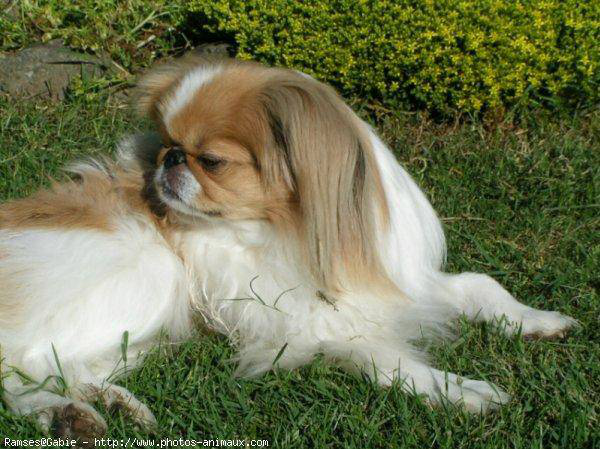

In [78]:
test_img = PIL.Image.open("dataset/dog-breeds/test/000621fb3cbb32d8935728e48679680e.jpg")
test_img